In [1]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from joblib import load
from setting import *
from loader import *
from models import load_model
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *
from XAI_interpret import prediction_gap_for_an_example, get_features_order
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/projects/GraphNEx/anaconda3/envs/GraphNEx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Arguments
name = "pancan"
model_name = 'GCN'
set_name = 'train'
exp = 1
gap = 1
XAI_method = "Integrated_Gradients"

In [3]:
# Path
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)
save_name = os.path.join(save_path, model_name, f"exp_{exp}")

In [4]:
# Seed
random.seed(exp)
np.random.seed(exp)
torch.manual_seed(exp)
if device == 'cuda':
    torch.cuda.manual_seed_all(exp)
    

In [5]:
# Load a dataset
train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
feat_name = np.array(feat_name)


934 weakly expressed genes are removed of the dataset.


In [6]:
# Load a model
softmax = True
n_layer, n_hidden_feat, graph_name = get_hyperparameters(name, model_name)
model = load_model(model_name, n_feat, n_class, softmax, device, save_path, n_layer, 
                   n_hidden_feat, graph_name)
checkpoint = torch.load(os.path.join(save_path, save_name, 'checkpoint.pt'))
model.load_state_dict(checkpoint['state_dict'])
model.eval()
    

Number of clusters at layer 1 14685


GCN(
  (layers): Sequential(
    (0): GCNConv(1, 2)
    (1): get_batch_cluster()
    (2): <function _max_pool_x at 0x7f834aaa6290>
    (3): ReLU()
  )
  (fc): Linear(in_features=29370, out_features=33, bias=True)
)

In [7]:
# Explainability scores
attr, y_pred, y_true, _, _, baseline, baseline_pred = load_attributions(XAI_method, 
                                                                            os.path.join(save_path, 
                                                                                         save_name,
                                                                                         XAI_method),
                                                                            set_name=set_name)
attr = transform_data(attr, transform='divide_by_norm')

In [8]:
# Baseline
base_class, studied_class = get_XAI_hyperparameters(name, n_class)
baseline = torch.tensor(baseline).to(torch.float32).to(device)
default_output = model(baseline).detach().cpu().numpy()

In [9]:
# Keep only studied examples  
data_loader = train_loader if set_name == "train" else test_loader
n_sample = 0
for x, y in data_loader:
    n_sample += x.shape[0]
X = np.zeros((n_sample, x.shape[1]), dtype="float32")
y = np.zeros((n_sample), dtype="int32")
n = 0
torch.manual_seed(1)
for x, label in data_loader:
    x = x.to(device)
    X[n:n+x.shape[0]] = transform(x).cpu().numpy()
    y[n:n+x.shape[0]] = label.cpu().numpy().astype("int32")
    n += x.shape[0]
transform = None
X = X[sum(y == c for c in studied_class).astype(bool)]
y = y[sum(y == c for c in studied_class).astype(bool)]


# Keep only correctly classified examples
indices = np.argwhere(y_pred == y_true).reshape(-1)
attr = attr[indices]
y_pred = y_pred[indices]
X = X[indices]
y = y[indices]


# Show metrics

In [10]:
rand_ex = random.randint(0, X.shape[0] - 1)

### Local rankings

In [11]:
local_ordering = np.argsort(-np.abs(attr[rand_ex]).reshape(1, -1), axis=1)
example = torch.tensor(X[rand_ex].copy().reshape(1, -1), dtype=torch.float32)
PGI_l, curve_PGI_l = prediction_gap_for_an_example(model, example, 
                                          y[rand_ex], n_class, transform, gap, 
                                          baseline, local_ordering)



local_ordering = np.argsort(np.abs(attr[rand_ex]).reshape(1, -1), axis=1)
example = torch.tensor(X[rand_ex].copy().reshape(1, -1), dtype=torch.float32)
PGU_l, curve_PGU_l = prediction_gap_for_an_example(model, example, 
                                          y[rand_ex], n_class, transform, gap, 
                                          baseline, local_ordering)
    

models
models


### Global rankings

In [12]:
ordered_feat_name = np.load(os.path.join(save_path, "order", f"order_IG_{model_name}_set_train_exp_{exp}.npy"), allow_pickle=True)
ordered_indices = np.array([np.argwhere(feat == feat_name)[0] for feat in ordered_feat_name]).reshape(-1)


In [13]:
baseline

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [14]:
# global_ordering = get_features_order(attr, _type="sum_decreasing").reshape(1, -1)
global_ordering = ordered_indices.copy().reshape(1, -1)
example = torch.tensor(X[rand_ex].copy().reshape(1, -1), dtype=torch.float32)
PGI_g, curve_PGI_g = prediction_gap_for_an_example(model, example, y[rand_ex], n_class, transform, gap, 
                                          baseline, global_ordering)

# global_ordering = get_features_order(attr, _type="sum_increasing").reshape(1, -1)
global_ordering = np.flip(ordered_indices.copy()).copy().reshape(1, -1)
example = torch.tensor(X[rand_ex].copy().reshape(1, -1), dtype=torch.float32)
PGU_g, curve_PGU_g = prediction_gap_for_an_example(model, example, y[rand_ex], n_class, transform, gap, 
                                          baseline, global_ordering)



models
models


pancan GCN
Local


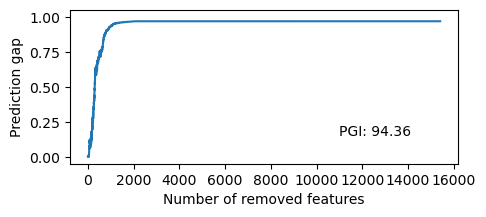

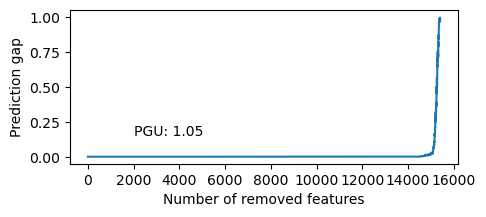

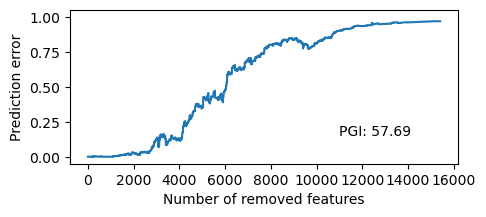

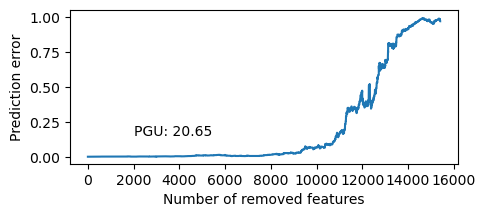

In [15]:
# Plots
print(name, model_name)
print("Local")
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGI_l) + 1) * gap, curve_PGI_l)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGI_l)) * gap, np.array([n_feat]))), 
             curve_PGI_l)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.text(11000, 0.15, f"PGI: {np.round(PGI_l * 100, 2)}")
plt.show()


plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGU_l) + 1) * gap, curve_PGU_l)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGU_l)) * gap, np.array([n_feat]))), 
             curve_PGU_l)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.text(2000, 0.15, f"PGU: {np.round(PGU_l * 100, 2)}")
plt.show()


plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGI_g) + 1) * gap, curve_PGI_g)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGI_g)) * gap, np.array([n_feat]))), curve_PGI_g)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction error")
plt.xlabel("Number of removed features")
plt.text(11000, 0.15, f"PGI: {np.round(PGI_g * 100, 2)}")
name = os.path.join(save_path, save_name, "figures", f"PGI_{set_name}")
#plt.savefig(name, bbox_inches='tight', dpi=150)
plt.show()


plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGU_g) + 1) * gap, curve_PGU_g)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGU_g)) * gap, np.array([n_feat]))), curve_PGU_g)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction error")
plt.xlabel("Number of removed features")
plt.text(2000, 0.15, f"PGU: {np.round(PGU_g * 100, 2)}")
name = os.path.join(save_path, save_name, "figures", f"PGU_{set_name}")
# plt.savefig(name, bbox_inches='tight', dpi=150)
plt.show()